# Setup

## Import Library

# Cek GPU

In [1]:
import os
import asyncio
import importlib
import time
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [2]:
print(torch.cuda.is_available())

True


# EDA

## Jumlah data

In [3]:
def count_images_in_folder(folder_path):
    """Menghitung jumlah gambar dalam folder dan subfolder."""
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]) 
    return count

# Path ke folder datasets
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung jumlah gambar di folder training
training_count = count_images_in_folder(training_path)
print(f"Jumlah gambar di folder training: {training_count}")

# Total jumlah gambar di folder testing
total_testing_count = count_images_in_folder(testing_path)
print(f"Jumlah gambar di folder testing: {total_testing_count}")

Jumlah gambar di folder training: 0
Jumlah gambar di folder testing: 0


## Distribusi datasets

Distribusi dataset untuk training: {'print': 2205, 'real': 2038, 'replay': 2376}


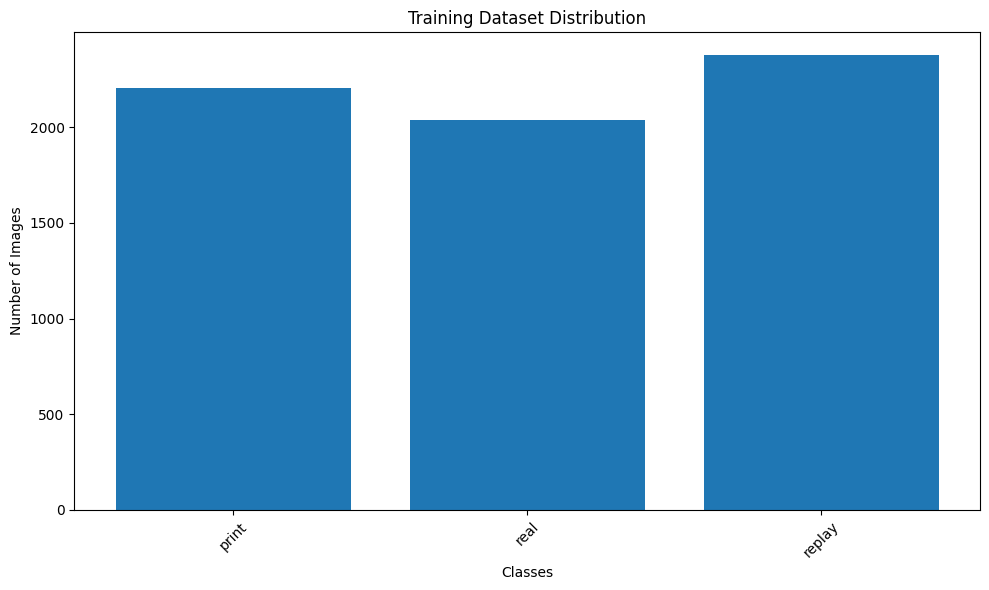

Distribusi dataset untuk testing: {'print': 550, 'real': 736, 'replay': 360}


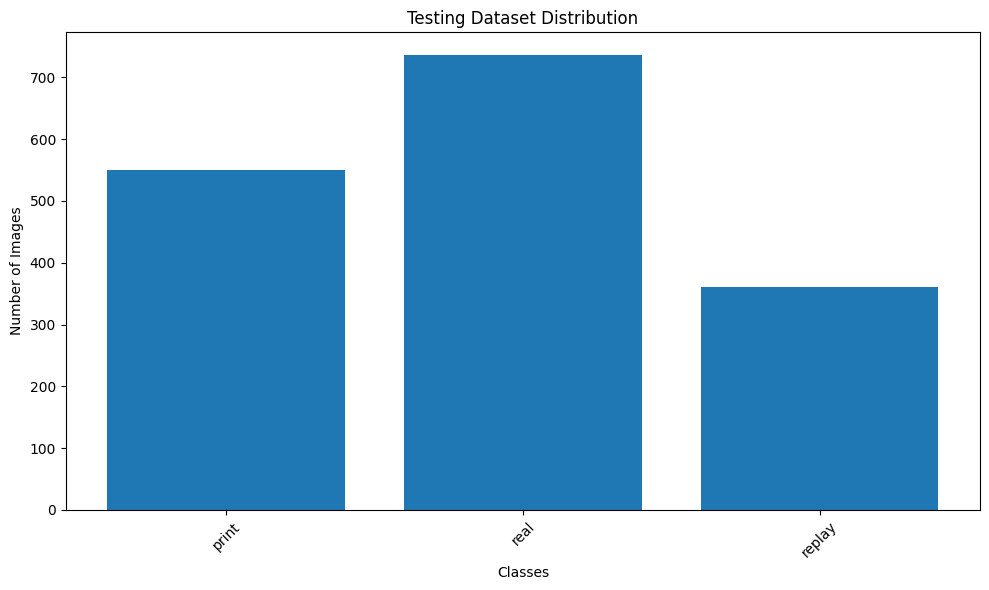

In [4]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder (kelas)
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder training dan testing
home_path = "/home/machi/code/python/TelU-TugasAkhir-LivenessDetection"
training_path = f"{home_path}/datasets/training"
testing_path = f"{home_path}/datasets/testing"

# Hitung distribusi kelas untuk training
training_class_counts = count_images_in_classes(training_path)
print(f"Distribusi dataset untuk training: {training_class_counts}")
plot_distribution(training_class_counts, "Training Dataset Distribution")

# Hitung distribusi kelas untuk testing
testing_class_counts = count_images_in_classes(testing_path)
print(f"Distribusi dataset untuk testing: {testing_class_counts}")
plot_distribution(testing_class_counts, "Testing Dataset Distribution")

## Preview datasets

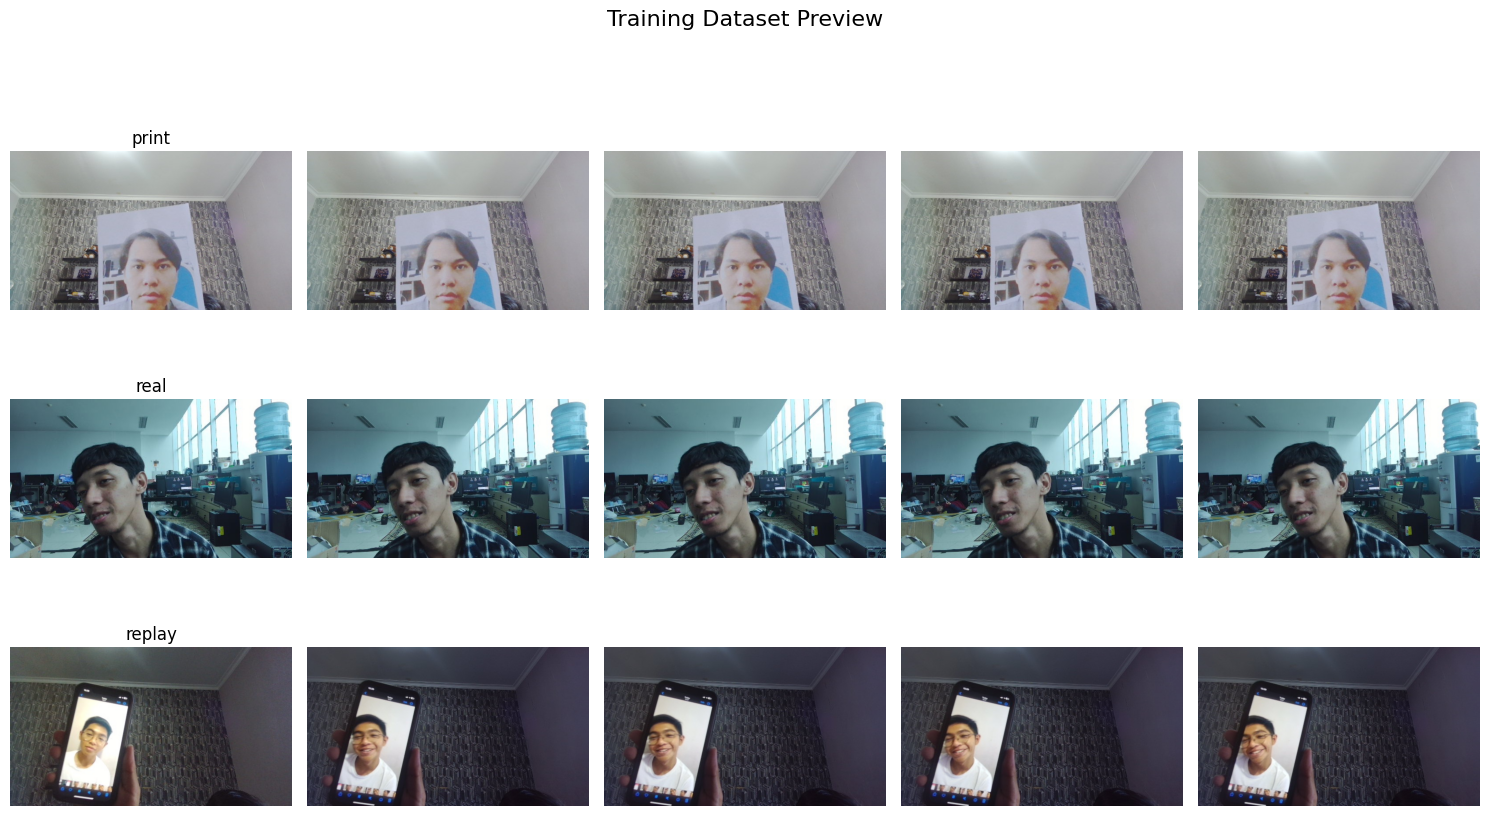

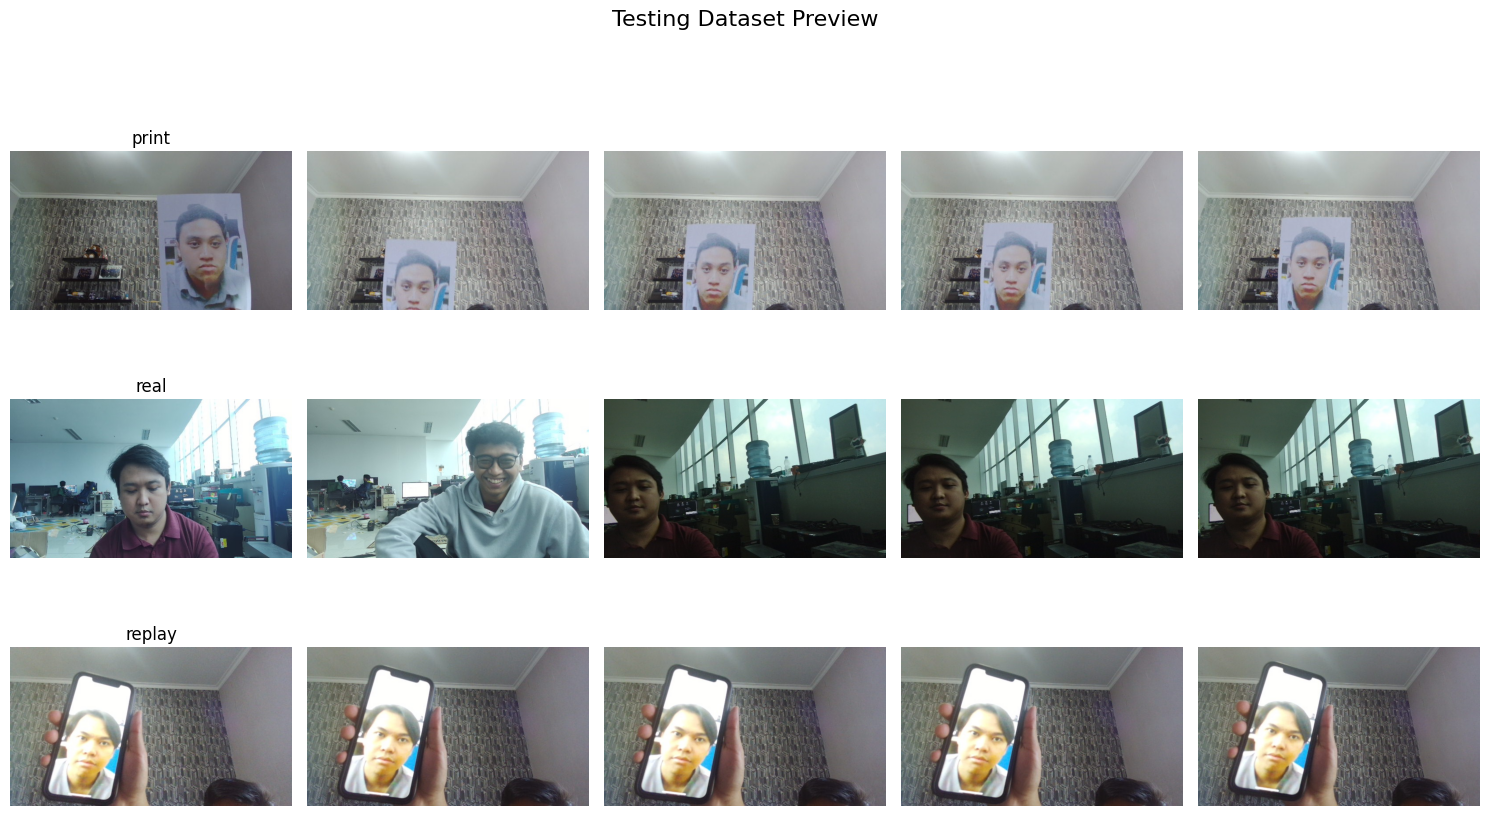

In [5]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        sample_images = images[:samples_per_class]  # Ambil sejumlah gambar untuk preview

        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Path ke folder training dan testing
training_path = f"{home_path}/datasets/training"
testing_path = f"{home_path}/datasets/testing"

# Preview gambar di folder training
preview_images(training_path, "Training Dataset Preview", samples_per_class=5)

# Preview gambar di folder testing
preview_images(testing_path, "Testing Dataset Preview", samples_per_class=5)

# EfficientNetV2

In [6]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model EfficientNetV2 dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2_Small": models.efficientnet_v2_s(weights=None),
    "EfficientNetV2_Medium": models.efficientnet_v2_m(weights=None),
    "EfficientNetV2_Large": models.efficientnet_v2_l(weights=None),
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,EfficientNetV2_Small,21.458.488
1,EfficientNetV2_Medium,54.139.356
2,EfficientNetV2_Large,118.515.272


# Swin Transformer

In [7]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model Swin Transformer dan menghitung jumlah parameternya
list_models = {
    "Swin-Tiny": models.swin_t(weights="IMAGENET1K_V1"),
    "Swin-Small": models.swin_s(weights="IMAGENET1K_V1"),
    "Swin-Base": models.swin_b(weights="IMAGENET1K_V1")
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,Swin-Tiny,28.288.354
1,Swin-Small,49.606.258
2,Swin-Base,87.768.224


# Training

## Variable Global

In [8]:
dataset_path = f"{home_path}/datasets/"
save_model_path = f"{home_path}/results/best_model/"
result_csv_path = f"{home_path}/results/csv/"
image_path = f"{home_path}/results/images/"

In [9]:
# Dataset directories
train_dir = os.path.join(dataset_path, "training")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "testing")

# Random seed
random.seed(42)

## Hyperparameter Settings

In [10]:
batch_size = 16
epochs_size = 30
optimizer = "Adam"
dropout_rate = 0.2
learning_rate = 0.001
trainable_percentage = 0.3

## Split Dataset

In [11]:
def count_images_in_folder(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return sum(len(files) for _, _, files in os.walk(folder_path) if files)

# Fungsi untuk melakukan split
def split_training_data(train_dir, val_dir, validation_split=0.1):
    if os.path.exists(val_dir):
        print(f"Folder '{val_dir}' sudah ada. Tidak melakukan split ulang.")
        return

    os.makedirs(val_dir, exist_ok=True)
    
    # Iterasi setiap kelas di folder training
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue
        
        os.makedirs(class_val_path, exist_ok=True)

        # Ambil semua file gambar di kelas ini
        all_images = [f for f in os.listdir(class_train_path) if os.path.isfile(os.path.join(class_train_path, f))]
        total_images = len(all_images)

        # Pilih 10% gambar secara acak untuk dipindahkan ke validation
        val_size = int(total_images * validation_split)
        val_images = random.sample(all_images, val_size)

        # Pindahkan gambar ke folder validation
        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dest_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dest_path)

# Hitung jumlah gambar sebelum split
print("Sebelum split:")
train_count_before = count_images_in_folder(train_dir)
val_count_before = count_images_in_folder(val_dir)
print(f"  Training: {train_count_before} gambar")
print(f"  Validation: {val_count_before} gambar")

# Lakukan split
split_training_data(train_dir, val_dir, validation_split=0.1)

# Hitung jumlah gambar setelah split
print("\nSetelah split:")
train_count_after = count_images_in_folder(train_dir)
val_count_after = count_images_in_folder(val_dir)
print(f"  Training: {train_count_after} gambar")
print(f"  Validation: {val_count_after} gambar")

Sebelum split:
  Training: 6619 gambar
  Validation: 735 gambar
Folder '/home/machi/code/python/TelU-TugasAkhir-LivenessDetection/datasets/validation' sudah ada. Tidak melakukan split ulang.

Setelah split:
  Training: 6619 gambar
  Validation: 735 gambar


## Data Augmentation

In [12]:
# Definisikan transformasi
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Definisikan path ke dataset
train_dir = f'{home_path}/datasets/training'
val_dir = f'{home_path}/datasets/validation'

# Buat dataset menggunakan ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Buat dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = 3

## Build Model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Pretrained EfficientNet

In [14]:
# Definisikan model pre-trained EfficientNetV2
# weights = EfficientNet_V2_S_Weights
weights = MobileNet_V3_Small_Weights
# model = efficientnet_v2_s(weights=weights, progress=True)
model = mobilenet_v2(weights=weights, progress=True)

/home/machi/.local/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_classes = 3  # Jumlah kelas Anda
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [16]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 30

best_vloss = 1_000_000.

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     train_correct = 0  
#     for images, labels in train_dataloader:
#         images = images.to(device)
#         labels = labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * images.size(0)
        
#         # Calculate training accuracy
#         _, preds = torch.max(outputs, 1)
#         train_correct += torch.sum(preds == labels.data)
    
#     train_loss /= len(train_dataloader.dataset)
#     train_accuracy = train_correct.double() / len(train_dataloader.dataset)
#     train_losses.append(train_loss)
#     train_accuracies.append(train_accuracy.item())

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     val_correct = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * images.size(0)
#             _, preds = torch.max(outputs, 1)
#             val_correct += torch.sum(preds == labels.data)
#     val_loss /= len(val_loader.dataset)
#     val_accuracy = val_correct.double() / len(val_loader.dataset)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy.item())

#     # Print training and validation metrics
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}')


EPOCH 1:


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 53.75 MiB is free. Including non-PyTorch memory, this process has 7.01 GiB memory in use. Of the allocated memory 6.83 GiB is allocated by PyTorch, and 58.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# # Mengubah jumlah kelas di lapisan klasifikasi terakhir
# num_classes = 3  # Jumlah kelas Anda
# base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_classes)

# # Pindahkan model ke device (CPU atau GPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# base_model.to(device)

# # Tentukan loss function
# criterion = nn.CrossEntropyLoss()

# # Tentukan optimizer
# learning_rate = 0.001
# optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

# # Fungsi untuk melatih model
# def train_model(model, dataloader, criterion, optimizer, num_epochs=30):
#     model.train()
    
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # Gunakan tqdm untuk menaLoss Functionmpilkan progress bar
#         with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
#             for images, labels in t:
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Kosongkan gradien
#                 optimizer.zero_grad()

#                 # Forward pass
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 # Backward pass dan optimisasi
#                 loss.backward()
#                 optimizer.step()

#                 # Hitung loss dan akurasi
#                 running_loss += loss.item() * images.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#                 epoch_loss = running_loss / total
#                 epoch_acc = correct / total

#                 # Update progress bar dengan metrik
#                 t.set_postfix(loss=epoch_loss, accuracy=epoch_acc)

# # Fungsi untuk mengevaluasi modelS
# def evaluate_model(model, dataloader, criterion):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Hitung loss dan akurasi
#             running_loss += loss.item() * images.size(0)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     eval_loss = running_loss / total
#     eval_acc = correct / total
#     eval_accuracy = accuracy_score(all_labels, all_preds)
#     return eval_accuracy, eval_loss

# # Melatih model
# train_model(base_model, train_dataloader, criterion, optimizer, num_epochs=30)

# # Mengevaluasi model
# eval_acc, eval_loss = evaluate_model(base_model, val_dataloader, criterion)
# print(f"Evaluation Accuracy: {eval_acc * 100:.2f}%, Evaluation Loss: {eval_loss:.4f}")

Epoch 1/30:   0%|          | 0/207 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 54.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 108.00 MiB is free. Including non-PyTorch memory, this process has 6.80 GiB memory in use. Of the allocated memory 6.63 GiB is allocated by PyTorch, and 44.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Model Pretrained Swin Transformer

In [ ]:
# Definisikan model pre-trained EfficientNetV2
weights = Swin_T_Weights.IMAGENET1K_V1
base_model = swin_t(weights=weights, progress=True)

# Mengubah jumlah kelas di lapisan klasifikasi terakhir
num_classes = 3  # Jumlah kelas Anda
in_features = base_model.head.in_features
base_model.head = nn.Linear(in_features, num_classes)

# Pindahkan model ke device (CPU atau GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# Tentukan loss function
criterion = nn.CrossEntropyLoss()

# Tentukan optimizer
learning_rate = 0.001
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

# Fungsi untuk melatih model
def train_model(model, dataloader, criterion, optimizer, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Gunakan tqdm untuk menaLoss Functionmpilkan progress bar
        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for images, labels in t:
                images = images.to(device)
                labels = labels.to(device)

                # Kosongkan gradien
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass dan optimisasi
                loss.backward()
                optimizer.step()

                # Hitung loss dan akurasi
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                epoch_loss = running_loss / total
                epoch_acc = correct / total

                # Update progress bar dengan metrik
                t.set_postfix(loss=epoch_loss, accuracy=epoch_acc)

# Fungsi untuk mengevaluasi modelS
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Hitung loss dan akurasi
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_loss = running_loss / total
    eval_acc = correct / total
    eval_accuracy = accuracy_score(all_labels, all_preds)
    return eval_accuracy, eval_loss

# Melatih model
train_model(base_model, train_dataloader, criterion, optimizer, num_epochs=30)

# Mengevaluasi model
eval_acc, eval_loss = evaluate_model(base_model, val_dataloader, criterion)
print(f"Evaluation Accuracy: {eval_acc * 100:.2f}%, Evaluation Loss: {eval_loss:.4f}")



# 3. Explicitly release memory
torch.cuda.empty_cache()  # Empty the CUDA cache
print("GPU memory released (hopefully!)")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 55.94 MiB is free. Including non-PyTorch memory, this process has 6.82 GiB memory in use. Of the allocated memory 6.69 GiB is allocated by PyTorch, and 14.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Model EfficientNet

In [ ]:
# def load_base_model(model_name, img_height, img_width, trainable_percentage, skema):
    

#     # Build model
#     model = build_model(base_model, train_generator.num_classes, dropout_rate)
    
#     # Compile model
#     compile_model(model, learning_rate)
    
#     return model


# def build_model(base_model, num_classes,dropout_rate):
#     model = models.Sequential([
#         base_model,
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(dropout_rate),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(dropout_rate),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     return model

# def compile_model(model, learning_rate):
    

# def train_model(model, train_generator, val_generator, epochs_size):
#     start_time = time.time()
#     history = model.fit(
#         train_generator,
#         epochs=epochs_size,
#         validation_data=val_generator
#     )
#     duration = time.time() - start_time
#     return history, duration

# def evaluate_model(model, test_generator):
#     eval_result = model.evaluate(test_generator)
#     return eval_result[1] * 100, eval_result[0]

# def save_model(model, save_path, timestamp, model_name):
#     model_save_path = os.path.join(save_path, f"{model_name}_{timestamp}.keras")
#     model.save(model_save_path)
#     return model_save_path

# def save_results_to_csv(results, csv_save_path):
#     df = pd.DataFrame(results)
#     if os.path.exists(csv_save_path):
#         existing_df = pd.read_csv(csv_save_path)
#         df = pd.concat([existing_df, df], ignore_index=True)
#     df.to_csv(csv_save_path, index=False)

# def plot_training_metrics(history, image_path, timestamp):
#     # Accuracy Plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history['accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.title('Training and Validation Accuracy')
#     plt.savefig(os.path.join(image_path, f"training_accuracy_{timestamp}.png"))
#     plt.show()

#     # Loss Plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Loss')
#     plt.savefig(os.path.join(image_path, f"training_loss_{timestamp}.png"))
#     plt.show()

# def plot_confusion_matrix(model, test_generator, image_path, timestamp):
#     y_true = test_generator.classes
#     y_pred = np.argmax(model.predict(test_generator), axis=1)
#     cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(test_generator.class_indices)))

#     fig, ax = plt.subplots(figsize=(12, 8))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
#     disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)

#     plt.title('Confusion Matrix', fontsize=16)
#     plt.tight_layout()
#     confusion_matrix_path = os.path.join(image_path, f"confusion_matrix_{timestamp}.png")
#     fig.savefig(confusion_matrix_path, bbox_inches='tight', dpi=300)
#     plt.show()
#     plt.close(fig)
#     return confusion_matrix_path

# def run_training(model):
    
#     # Train model
#     history, training_duration = train_model(model, train_generator, val_generator, epochs_size)
    
#     # Evaluate model
#     test_accuracy, test_loss = evaluate_model(model, test_generator)
    
#     # Save model
#     timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#     save_model(model, save_model_path, timestamp,model_name)
    
#     # Save results
#     results = {
#         "Timestamp": [timestamp],
#         "Model": [model_name],
#         "Skema":[skema],
#         "Batch Size": [batch_size],
#         "Epochs": [epochs_size],
#         "Training Accuracy": [max(history.history['accuracy']) * 100],
#         "Validation Accuracy": [max(history.history['val_accuracy']) * 100],
#         "Testing Accuracy": [test_accuracy],
#         "Training Loss": [min(history.history['loss'])],
#         "Validation Loss": [min(history.history['val_loss'])],
#         "Testing Loss": [test_loss],
#         "Training Duration (seconds)": [training_duration],
#         "Training Duration (minutes)": [f"{training_duration / 60:.2f}"],
#         "Trainable Percentage": [trainable_percentage_modifikasi * 100 if "Modifikasi" in model_name else trainable_percentage * 100],
#         "Total Parameter": [f"{model.count_params():,}".replace(",", ".")]
#     }
#     save_results_to_csv(results, os.path.join(result_csv_path, "training_results_runpod.csv"))

#     show_classification_report(model, test_generator, result_csv_path, timestamp)

#     return history, image_path, timestamp, model, training_duration, test_accuracy

# def plot_history(history, image_path, timestamp, model, training_duration, test_accuracy):
#     # Plot metrics
#     plot_training_metrics(history, image_path, timestamp)
    
#     # Plot confusion matrix
#     confusion_matrix_path = plot_confusion_matrix(model, test_generator, image_path, timestamp)
    

# def show_classification_report(model, test_generator, save_path, timestamp):
#     y_true = test_generator.classes
#     y_pred = np.argmax(model.predict(test_generator), axis=1)
#     class_labels = list(test_generator.class_indices.keys())

#     print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## Train Model

### EfficientNet V2 Small

### EfficientNet V2 Medium

### EfficientNet V2 Large

### Swin Transformer Tiny

### Swin Transformer Small

### Swin Transformer Base